In [2]:
import pandas as pd
import numpy as np

from skopt.space import Real, Integer
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

from scipy.stats import qmc  
from GPyOpt.methods import BayesianOptimization

from sklearn.metrics import mean_squared_error, r2_score

Neural Network Model for Hyper Parameter Tuning

In [3]:
def benchmark(X, Y):
    return (X * np.sin(X)) + (Y * np.sin(Y))


In [4]:
# Random seed
np.random.seed(1)

# Number of observations to train the GP on before starting the active learning loop
pretrain_n = 10

# Standard deviation of simulated response
sim_stdev = 0.02

# Number of bayesian optimization iterations for calibrating simulation model
max_bo_iter = 150

# Random seed
r = np.random.default_rng(seed=2)

In [5]:
ran_err = lambda n, x: r.normal(0, x, n)
sim_err = lambda x, y, a, b: 0.1 * (a - 4) * x + 0.05 * (b + 3) * y**2 + 0.03 * x * y + r.normal(0, sim_stdev)

In [6]:
# Generate 10 random data points for 2 inputs (X, Y) within specified bounds
X = np.random.uniform(-5, 18, pretrain_n)
Y = np.random.uniform(-5, 18, pretrain_n)

# Calculate the outputs using Himmelblau's Function
output1 = benchmark(X, Y) + ran_err(pretrain_n, 0.05)

# Generate Initial Dataset of Physical Experiments
df = pd.DataFrame({
    'x': X,
    'y': Y,
    'z': output1,
})


In [7]:
sim_eval = lambda x, y, a, b: benchmark(x, y) + sim_err(x, y, a, b)

In [8]:
df

x          y          z
0   4.591506   4.641474  -9.178355
1  11.567463  10.760049 -20.215970
2  -4.997369  -0.297598  -4.729201
3   1.953649  15.196701   9.125555
4  -1.624615  -4.370085  -2.404303
5  -2.876212  10.420753  -7.934456
6  -0.716015   4.598010  -4.114257
7   2.947897   7.849866   8.455922
8   4.125652  -1.771100  -1.685894
9   7.392785  -0.443666   6.783145

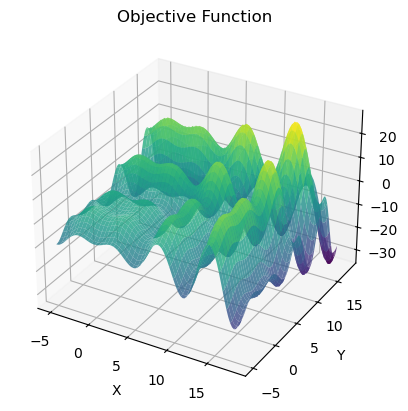

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create the grid of input values
x_range = np.linspace(-5, 18, 100)
y_range = np.linspace(-5, 18, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)

# Evaluate function on grid
z_grid = benchmark(x_grid, y_grid)

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Objective Function')

# Show the plot
plt.show()

In [10]:
# Define the hyperparameter space
hyp_space  = [
    Integer(2, 10, name='num_layers'), # Num of layers in the network (depth)
    Integer(50, 200, name='num_units'), # Num of neurons in each hidden layer (width)
    Real(0.00001, 0.1, prior='log-uniform', name='learning_rate'), # Steps size at each iteration 
    Real(0.0, 0.5, name='dropout_rate'), # Probability of droping out a neuron
    Integer(20, 150, name='batch_size'), # Num of samples per batch
    Integer(50, 200, name='epochs') # Num of epochs (iterations over the entire dataset) during training
]

# Defining the Neural Network Model
def NN_model(num_layers, num_units, learning_rate, dropout_rate):
    inputs = Input(shape=(2,))
    x = Dense(num_units, activation='relu', kernel_regularizer='l2')(inputs)
    for _ in range(num_layers - 1):
        x = Dense(num_units, activation='relu', kernel_regularizer='l2')(x)
        x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Function for MC Dropout predictions
def mc_dropout_predictions(model, X, num_samples=50):
    predictions = np.zeros((num_samples, X.shape[0]))
    for i in range(num_samples):
        predictions[i, :] = model(X, training=True).numpy().flatten()
    prediction_mean = predictions.mean(axis=0)
    prediction_std = predictions.std(axis=0)
    return prediction_mean, prediction_std


In [11]:
# Define the known global maxima for the Himmelblau's function
global_maxima_points = [
    {"X": 14.28, "Y":  14.28, "Z": benchmark(14.28,  14.28)},
]

# Create a DataFrame for the global maxima
global_maxima_df = pd.DataFrame(global_maxima_points)
global_maxima_df

X      Y          Z
0  14.28  14.28  28.269165

In [12]:
rmse_list = []
r2_list = []
iteration_list = []

In [13]:
def perform_iteration(df, iteration, rmse_list, r2_list, iteration_list):

    def sim_all(x):
        df["a"] = x[0,0]
        df["b"] = x[0,1]
        df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
        df["diff"] = df["z"] - df["sim_z"]
        return (df["diff"]**2).sum()

    bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (-10,10)},
            {'name': 'b', 'type': 'continuous', 'domain': (-10,10)}]

    # Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
    bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
    bo.run_optimization(max_iter=max_bo_iter)
    df["a"] = bo.x_opt[0]
    df["b"] = bo.x_opt[1]
    print(bo.x_opt)

    # Create the grid of input values
    x_range = np.linspace(-5, 18, 100)
    y_range = np.linspace(-5, 18, 100)
    x_grid, y_grid = np.meshgrid(x_range, y_range)
    sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[1])

    # Create the plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)

    # Customize the plot
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('True Function with Simulation Calibrated Errors')

    # Show the plot
    plt.show()

    # Generate points using Latin Hypercube Sampling (LHS)
    n_samples = 100
    lhs= qmc.LatinHypercube(d=2, optimization="random-cd")
    lhs_samples = lhs.random(n=n_samples)
    bounds = np.array([[-5, 18], [-5, 18]])  # Bounds for Design Space

    scaled_samples = qmc.scale(lhs_samples, bounds[:, 0], bounds[:, 1])

    selected_points_df = pd.DataFrame(scaled_samples, columns=['x', 'y'])
    selected_points_df['sim_z'] = sim_eval(selected_points_df['x'], selected_points_df['y'], bo.x_opt[0], bo.x_opt[1])

    sim_df = df[["x", "y", "sim_z"]]
    sim_df = pd.concat([sim_df, selected_points_df], axis=0, ignore_index=True)

    # Train the model with the best hyperparameters on the entire dataset
    best_model = NN_model(
        num_layers=6,
        num_units=300,
        learning_rate=0.0007,
        dropout_rate=0.5
    )

    # Standardize the Dataset of Simulation Responses
    scaler= StandardScaler().fit(sim_df[['x', 'y']])
    X_scaled = scaler.transform(sim_df[['x', 'y']])

    # Train the best model on the combined standardized dataset
    best_model.fit(X_scaled, sim_df[['sim_z']], epochs=500, batch_size=150, verbose=1)

    # Create a meshgrid and combine into a single array
    xy_grid = np.c_[x_grid.ravel(), y_grid.ravel()]

    # Perform MC Dropout predictions on the entire grid
    xy_grid_scaled = scaler.transform(xy_grid)
    pred_mean, pred_std = mc_dropout_predictions(best_model, xy_grid_scaled)

    # Ploting mean predictions and confidence intervals
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Reshaping predictions back to grid shape
    pred_mean_grid = pred_mean.reshape(x_grid.shape)
    pred_upper_grid = (pred_mean + (1.96 * pred_std)).reshape(x_grid.shape)
    pred_lower_grid = (pred_mean - (1.96 * pred_std)).reshape(x_grid.shape)

    mean_surface = ax.plot_surface(x_grid, y_grid, pred_mean_grid, color='blue', alpha=0.5, label='Mean Prediction')
    upper_surface = ax.plot_surface(x_grid, y_grid, pred_upper_grid, color='red', alpha=0.3, label='Upper Bound (95% CI)')
    lower_surface = ax.plot_surface(x_grid, y_grid, pred_lower_grid, color='green', alpha=0.3, label='Lower Bound (95% CI)')

    # Customize the plot
    ax.set_title('Neural Network of Simulated Response with Confidence Intervals')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Output')

    # Legend
    legend_elements = [mean_surface, upper_surface, lower_surface]
    fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.1, 0.9))

    # Show the plot
    plt.show()
    
    x_range = [(-5, 18)]
    y_range = [(-5, 18)]
    def p_nn(xy):
        xy = np.array(xy).reshape(1, -1)  # Ensure correct shape (1,2)
        xy_scaled = scaler.transform(xy)
        pred_mean, pred_std = mc_dropout_predictions(best_model, xy_scaled)
        # Check if the point is inside the valid domain
        if (x_range[0][0] <= xy[0, 0] <= x_range[0][1] and 
                y_range[0][0] <= xy[0, 1] <= y_range[0][1]):
            
            probability = max(pred_mean + 1.96 * pred_std - sim_df["sim_z"].median(), 1e-6)  # Avoid zero
            return probability
        else:
            return 1e-10  # Keep very small but nonzero probability for out-of-bounds case


    def metropolis_step(xy, sig):
        prop_xy = xy + np.random.normal(0, sig, size=xy.shape)  # Generate a candidate

        # Ensure proposed point is inside the valid bounds
        if not (x_range[0][0] <= prop_xy[0, 0] <= x_range[0][1] and 
                y_range[0][0] <= prop_xy[0, 1] <= y_range[0][1]):
            return xy  # Reject out-of-bounds proposals

        u = np.random.uniform(0, 1)
        if u < min(1.0, p_nn(prop_xy) / p_nn(xy)):
            return prop_xy  # Accept move
        else:
            return xy  # Stay at current point


    def mh_sampler(sig, sample_size, burn_in, lag):
        # Start at the point with the largest simulated response
        max_idx = np.argmax(sim_df["sim_z"])
        x_init = sim_df["x"].iloc[max_idx]
        y_init = sim_df["y"].iloc[max_idx]
        xy = np.array([[x_init, y_init]])

        # Burn-in phase
        for i in range(burn_in):
            xy = metropolis_step(xy, sig)

        # Sampling phase
        output = xy
        for i in range(sample_size - 1):
            for j in range(lag):
                xy = metropolis_step(xy, sig)
            output = np.vstack((output, xy))  # Stack valid samples

        return output  # Returns an array of shape (sample_size, 2)

    # Find point with highest NN predicted mean response
    flat_pred_mean = pred_mean.flatten()
    max_idx = np.argmax(flat_pred_mean)

    x_max = xy_grid[max_idx, 0]
    y_max = xy_grid[max_idx, 1]
    max_point = np.array([[x_max, y_max]])


    X_mh = mh_sampler(sig=5, sample_size=pretrain_n - 1, burn_in=50, lag=20)

    X_all = np.vstack([max_point, X_mh])

    physical_test_points = pd.DataFrame(X_all, columns=["x", "y"])

    # Generate predictions for the heatmap
    pred_mean_grid = pred_mean.reshape(x_grid.shape)

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    heatmap = plt.contourf(x_grid, y_grid, pred_mean_grid, cmap='viridis', levels=50)
    plt.colorbar(heatmap, label="Neural Network Response")

    # Overlay sampled points
    plt.scatter(sim_df['x'], sim_df['y'], color='white', edgecolor='black', label='Simulation Sampled Points')
    plt.scatter(physical_test_points['x'], physical_test_points['y'], color='purple', edgecolor='black', label='Next Physical Test Points')

    # Customize the plot
    plt.title("Heatmap of Neural Network Response")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.legend()
    plt.show()

    # Add validated data points to original data frame
    physical_test_points["z"] = benchmark(physical_test_points['x'], physical_test_points['y']) + ran_err(pretrain_n, 0.05)
    physical_test_points["a"] = bo.x_opt[0]
    physical_test_points["b"] = bo.x_opt[1]
    physical_test_points["sim_z"] = sim_eval(physical_test_points["x"], physical_test_points["y"], physical_test_points["a"], physical_test_points["b"])
    physical_test_points["diff"] = physical_test_points["z"] - physical_test_points["sim_z"]

    # Heatmap of Simulated Points 
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot the heatmap for sim_z_grid
    heatmap = ax.contourf(x_grid, y_grid, sim_z_grid, levels=100, cmap='viridis', alpha=0.8)

    # Overlay scatter points for sampling points
    ax.scatter(df["x"], df["y"], color='blue', marker='o', label='Previous Sampled Points')
    ax.scatter(sim_df["x"], sim_df["y"], edgecolor='black', facecolors='none', marker='o', label='Sampled Simulation Points')
    ax.scatter(physical_test_points["x"], physical_test_points["y"], color='purple', marker='o', label='Next Physical Test Points')
    for i, row in physical_test_points.iterrows():
        ax.text(row["x"], row["y"], f"({row['x']:.1f}, {row['y']:.1f})", 
                fontsize=8, ha='center', va='bottom', color='black', 
                bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.5))
    # Overlay scatter points for global maxima
    ax.scatter(global_maxima_df['X'], global_maxima_df['Y'], color='red', marker='o', label='Global Maximum Point')

    # Customize the plot
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('True Function with Simulation Calibrated Errors (Heatmap)')
    ax.legend()

    # Add a color bar
    cbar = plt.colorbar(heatmap, ax=ax)
    cbar.set_label('Function Value (Z)')

    # Show the plot
    plt.show()

    # Add points to original dataframe
    df = pd.concat([df, physical_test_points], axis=0, ignore_index=True)

    # Track Physical Test Points
    print(f"Selected {len(physical_test_points)} new test points. Median diff: {physical_test_points['diff'].median():.4f}")

    # Compute RMSE and R² between true and simulated values
    rmse = mean_squared_error(df["z"], df["sim_z"], squared=False)
    r2 = r2_score(df["z"], df["sim_z"])

    # Log metrics
    rmse_list.append(rmse)
    r2_list.append(r2)
    iteration_list.append(iteration)

    print(f"[Iteration {iteration}] RMSE: {rmse:.4f}, R²: {r2:.4f}")
    

    return df

In [15]:
n_iterations = 6

[ 2.73047019 -3.09689622]


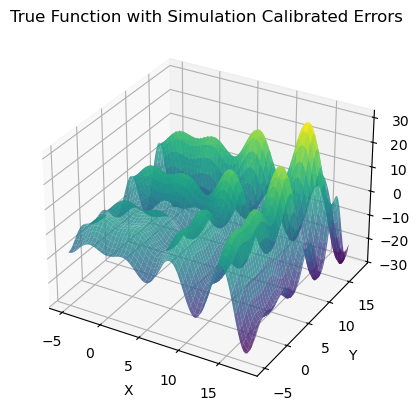

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 113.9202
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 113.7188
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 113.4144
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 113.0730
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 112.7836
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 112.6304
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 112.4654
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 111.9875
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 111.9313
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 111.2594
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 110.8743
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 111.5996
Epoch 13/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 110.7085
Epoch 14/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 110.1741
Epoch 15/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 

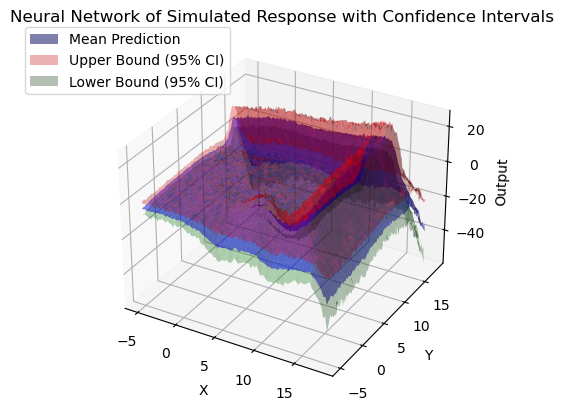

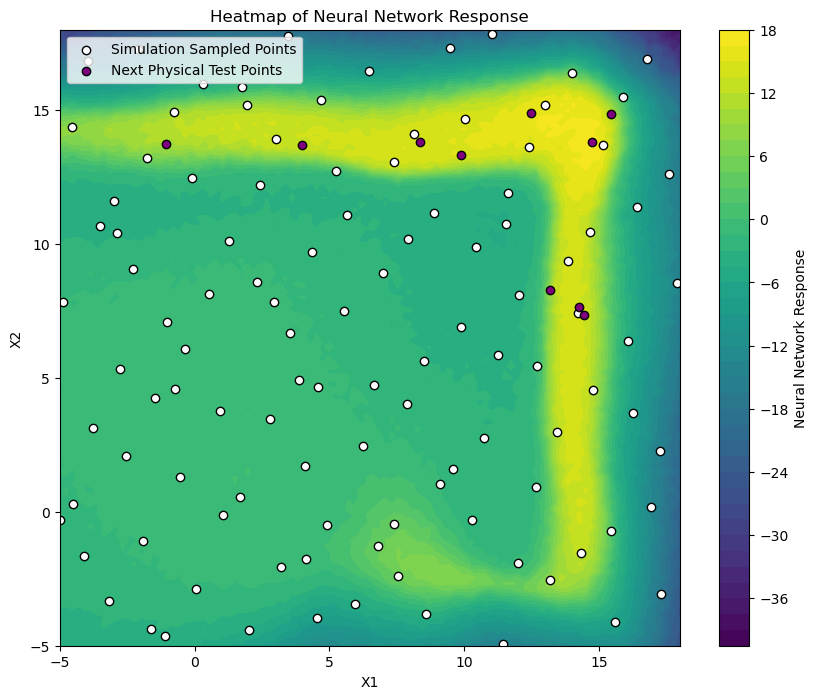

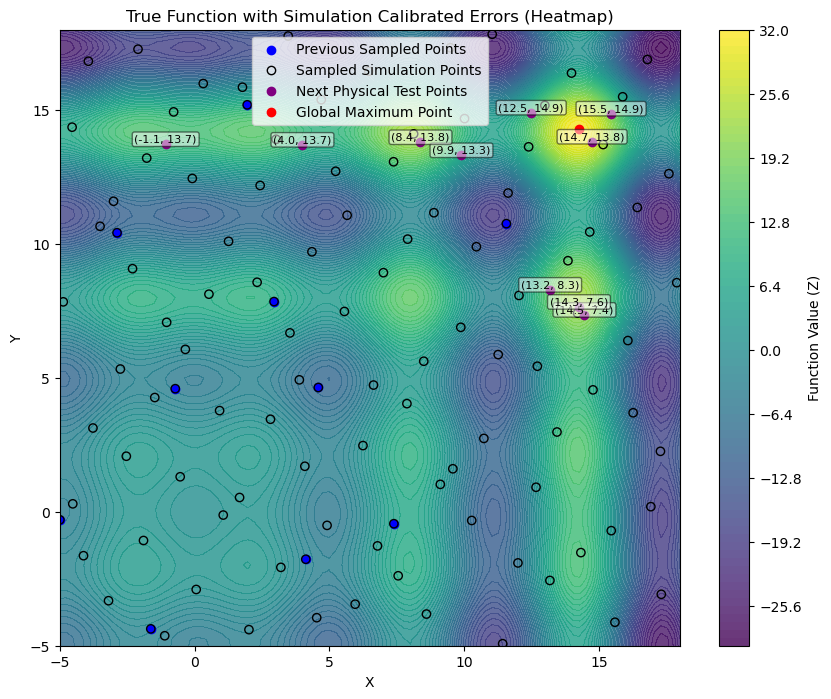

Selected 10 new test points. Median diff: -1.4272
[Iteration 0] RMSE: 1.6530, R²: 0.9800
[ 1.56920011 -3.1549597 ]


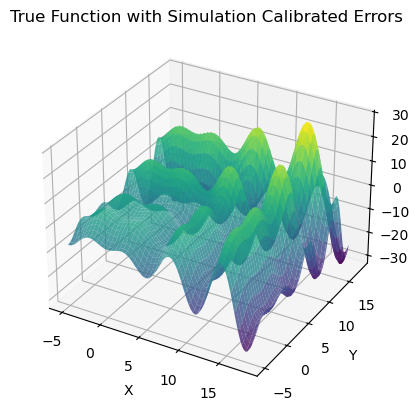

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 1121.9663
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1121.5118
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1120.4194
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1118.6632
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1118.5820
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1114.9655
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1115.2681
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1109.8702
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1107.2107
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1104.9630
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1103.0038
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1096.6233
Epoch 13/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1081.9650
Epoch 14/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1081.9723
Epoch 15/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms

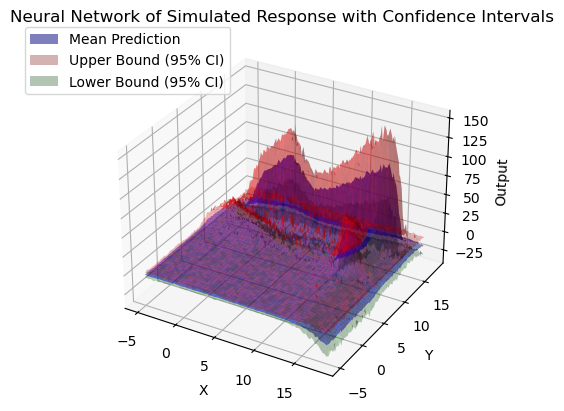

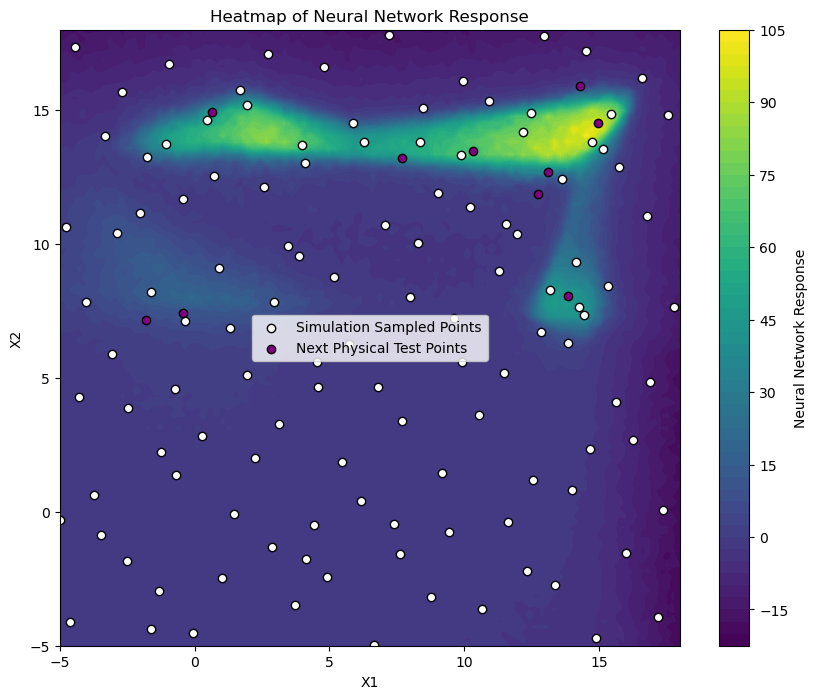

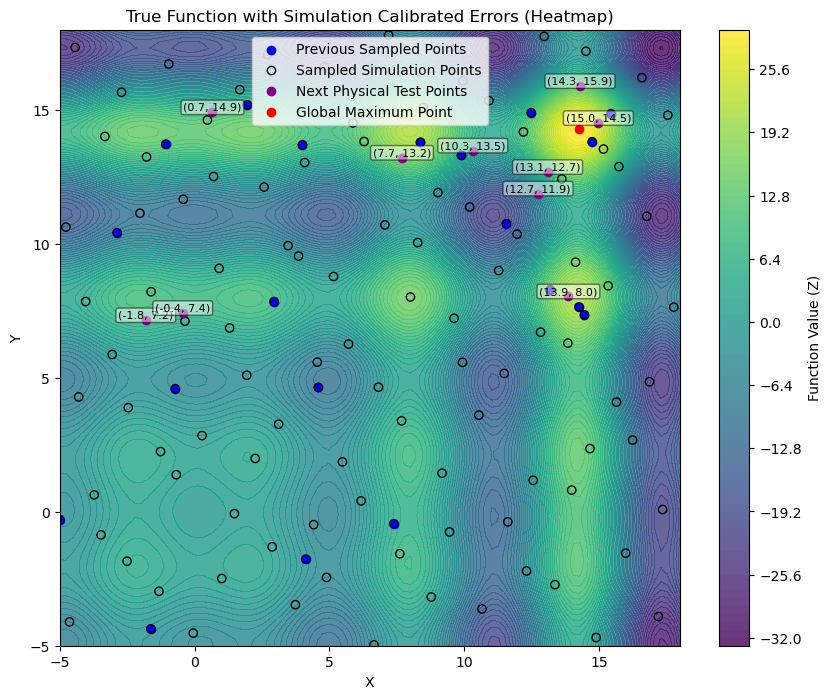

Selected 10 new test points. Median diff: -0.0780
[Iteration 1] RMSE: 56.8762, R²: -26.8331
[ 1.23035086 -3.12828102]


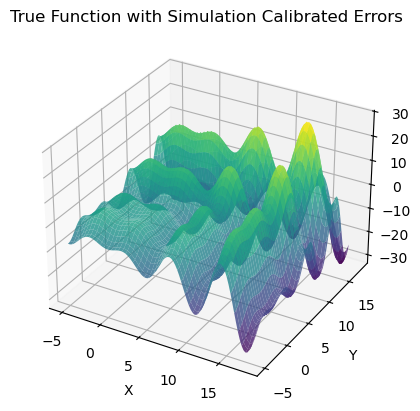

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 135.9900
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 135.7526
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 135.4231
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 135.4085
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 135.6584
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 135.2885
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 135.0269
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 135.0910
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 134.7244
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 134.7723
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 134.7833
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 134.2320
Epoch 13/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 134.2919
Epoch 14/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 133.9176
Epoch 15/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 

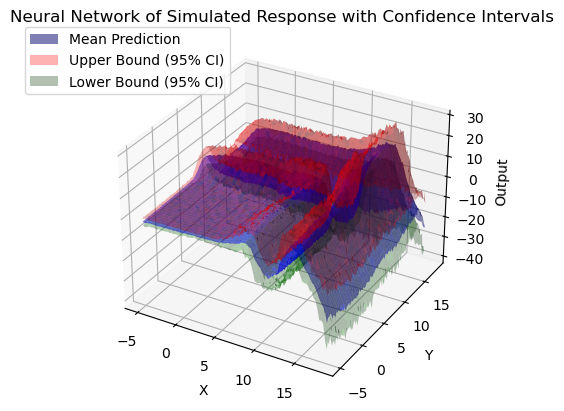

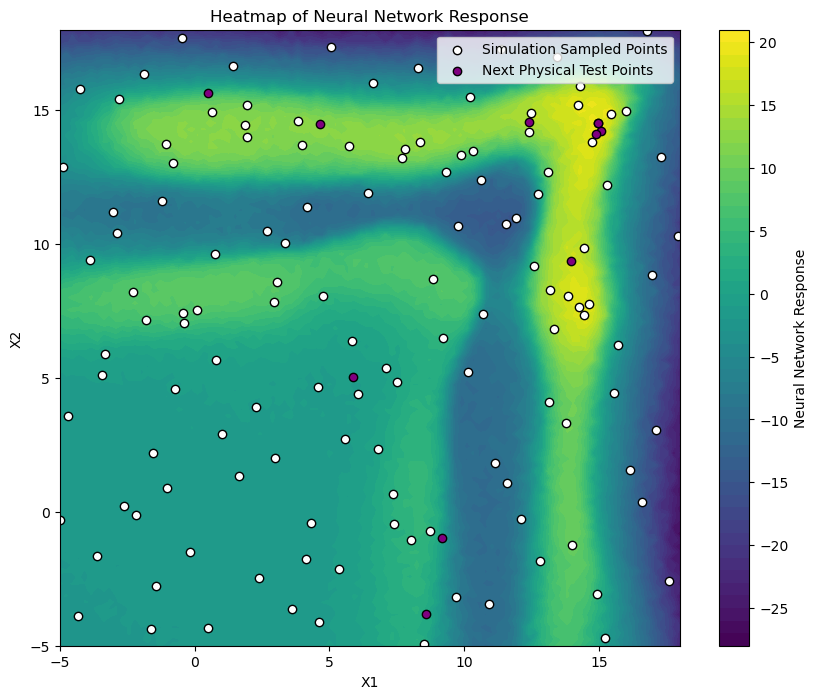

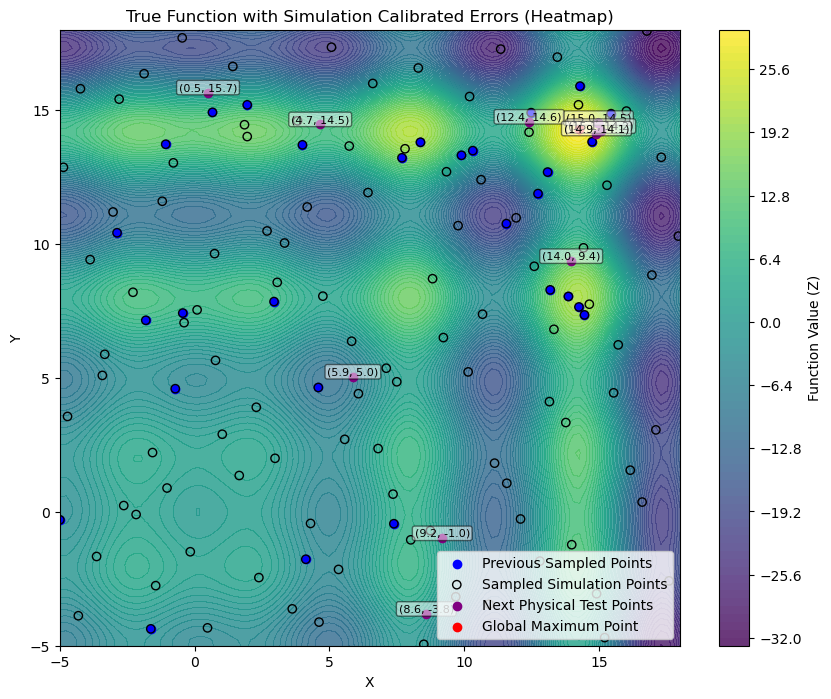

Selected 10 new test points. Median diff: 0.5730
[Iteration 2] RMSE: 1.2905, R²: 0.9855
[ 1.665383   -3.17237751]


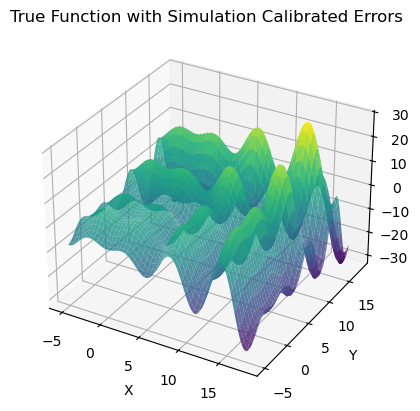

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 146.0397
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 146.0535
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 145.5821
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 145.9559
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 145.6703
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 145.6656
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 145.3492
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 144.9886
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 144.9431
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 144.7063
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 144.5554
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 144.4030
Epoch 13/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 145.2649
Epoch 14/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 143.9575
Epoch 15/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 

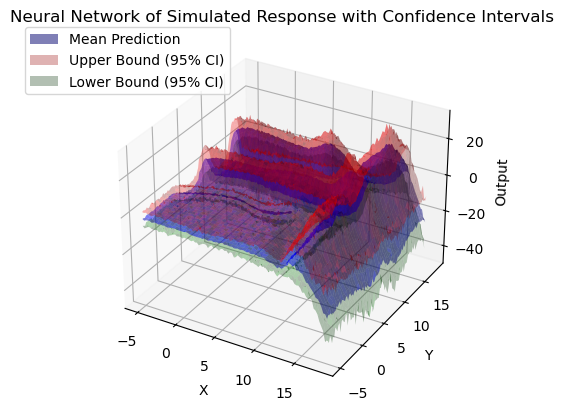

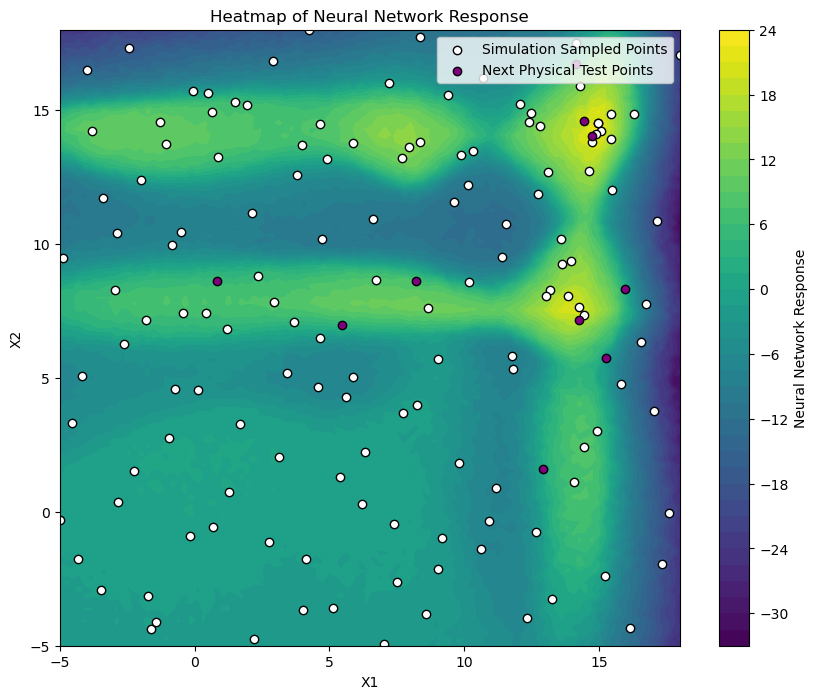

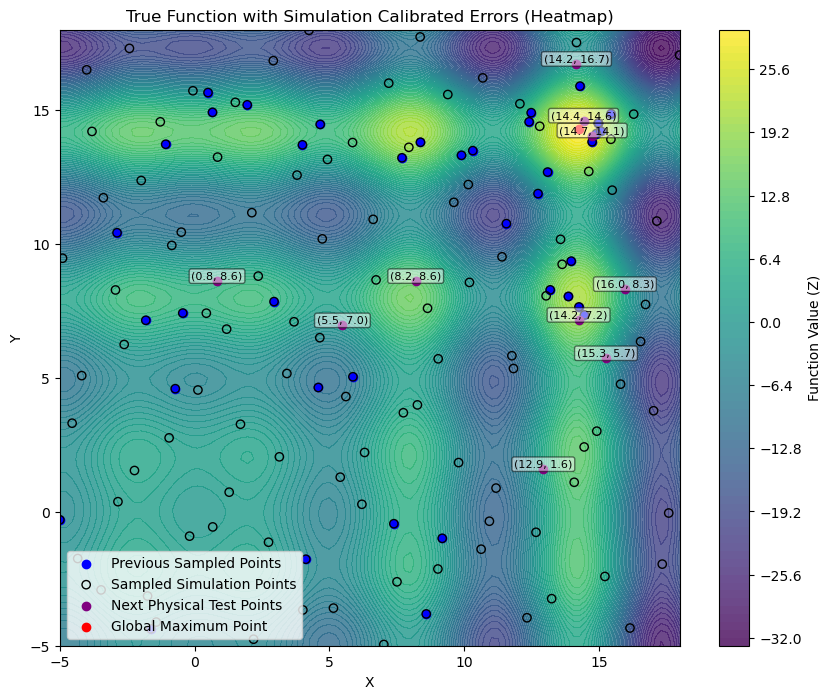

Selected 10 new test points. Median diff: 0.5240
[Iteration 3] RMSE: 1.2466, R²: 0.9861
[ 1.5526072  -3.18448238]


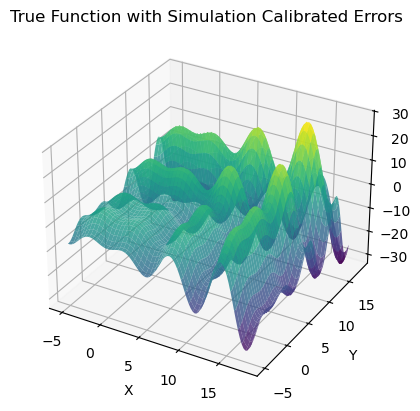

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 151.5616
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 151.1502
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 150.9733
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 150.6058
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 150.8908
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 151.0582
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 150.2617
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 150.0677
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 150.3006
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 150.2006
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 150.2905
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 149.6578
Epoch 13/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 149.5073
Epoch 14/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 149.3823
Epoch 15/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 

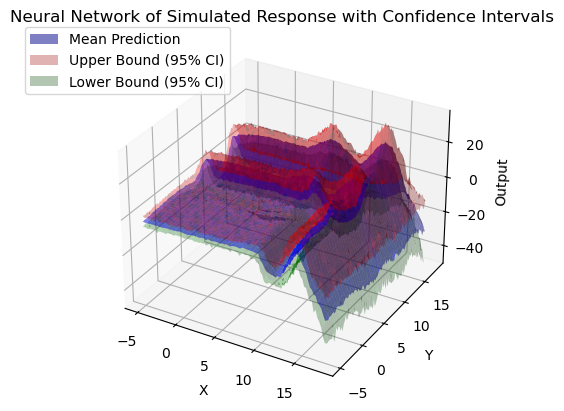

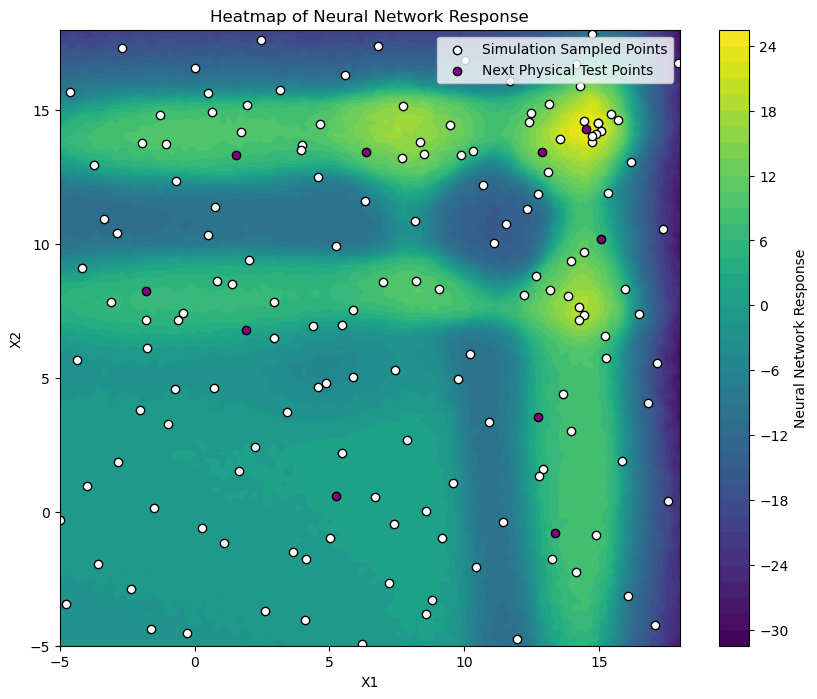

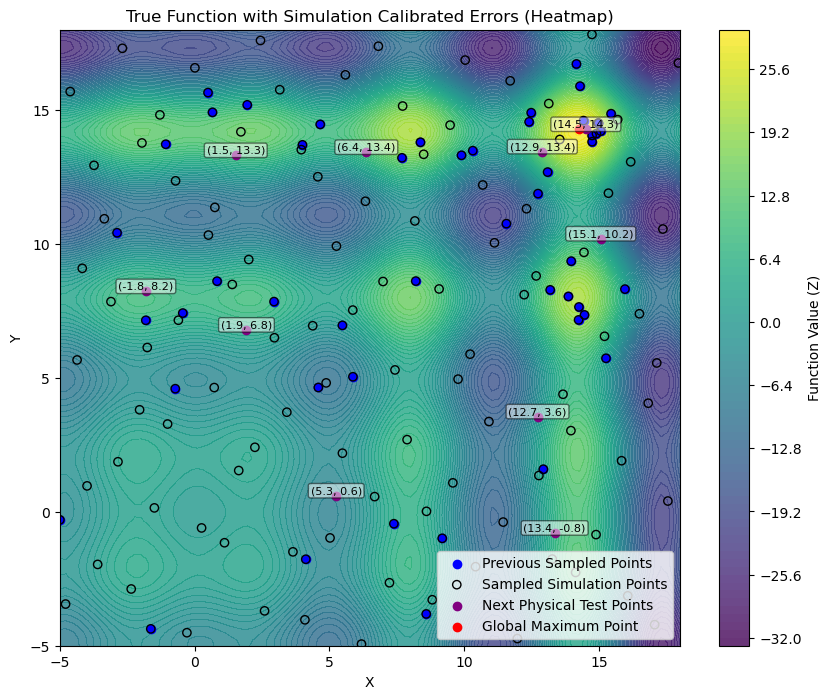

Selected 10 new test points. Median diff: 0.7071
[Iteration 4] RMSE: 1.8284, R²: 0.9681
[ 1.70533204 -3.1908449 ]


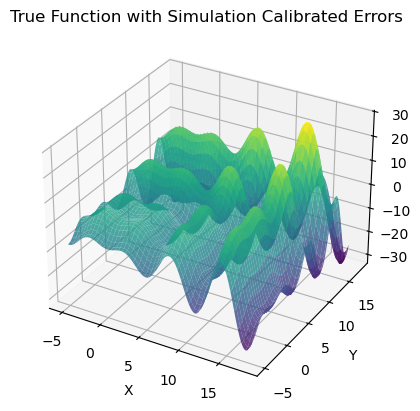

Epoch 1/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 196.0190
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 191.0374 
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 188.9220 
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 185.4254 
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 183.4309 
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 187.0831 
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 181.4333 
Epoch 8/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 179.1346 
Epoch 9/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 171.7304 
Epoch 10/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 164.4303 
Epoch 11/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 164.3438 
Epoch 12/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 162.1604 
Epoch 13/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 159.8175 
Epoch 14/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 156.6217 
Epoch 15/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss:

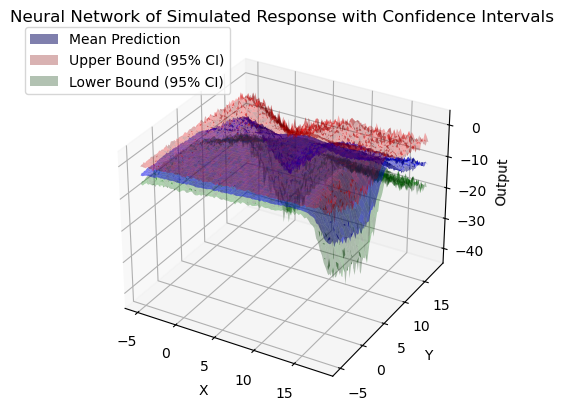

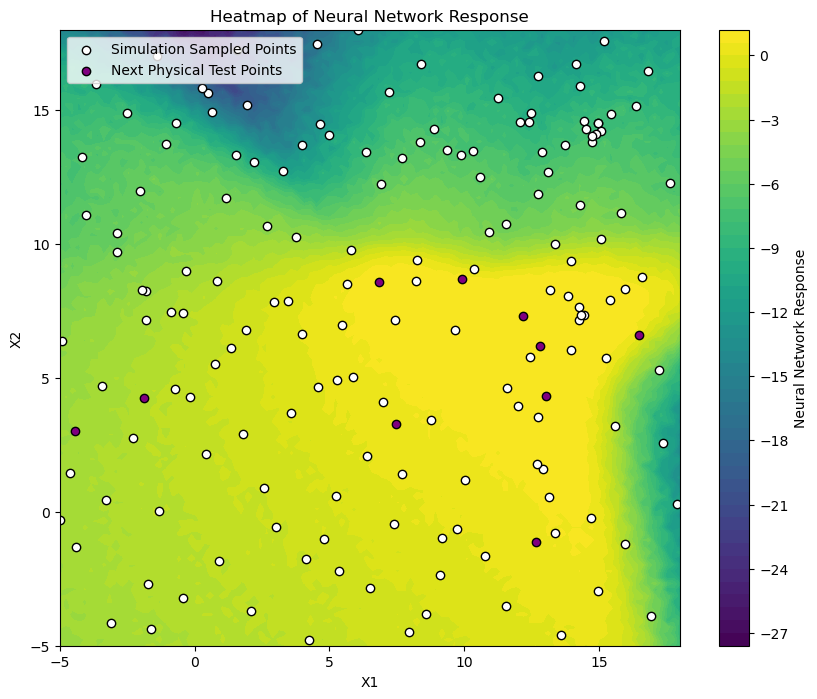

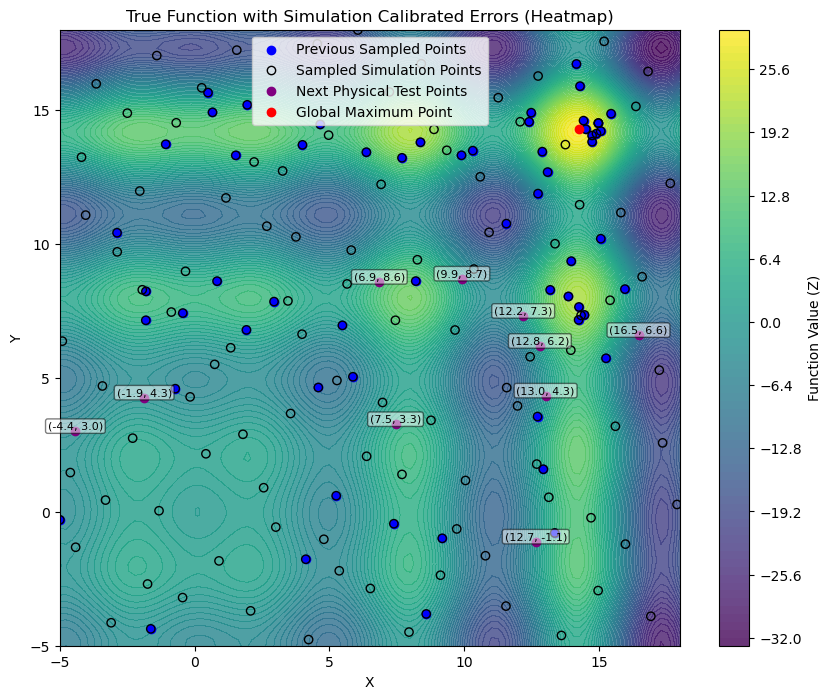

Selected 10 new test points. Median diff: 0.8045
[Iteration 5] RMSE: 21.1293, R²: -3.4280


In [16]:
for i in range(n_iterations):
    df = perform_iteration(df, iteration=i, rmse_list=rmse_list, r2_list=r2_list, iteration_list=iteration_list)

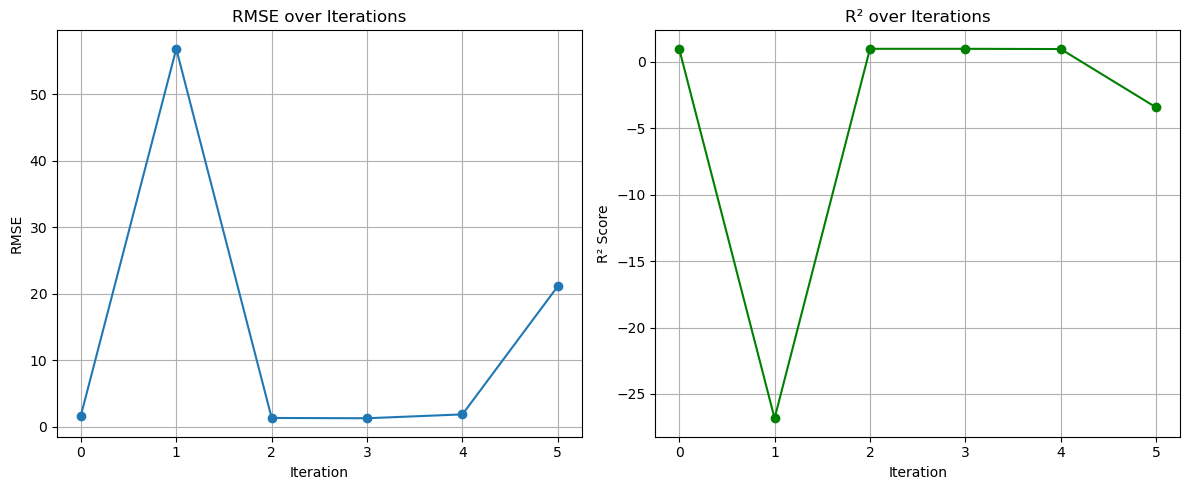

In [17]:
plt.figure(figsize=(12, 5))

# Plot RMSE
plt.subplot(1, 2, 1)
plt.plot(iteration_list, rmse_list, marker='o', label='RMSE')
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.title("RMSE over Iterations")
plt.grid(True)

# Plot R²
plt.subplot(1, 2, 2)
plt.plot(iteration_list, r2_list, marker='o', color='green', label='R² Score')
plt.xlabel("Iteration")
plt.ylabel("R² Score")
plt.title("R² over Iterations")
plt.grid(True)

plt.tight_layout()
plt.show()

In [18]:
df.to_excel('sinx_output1.xlsx', index=False)